## Introducation: Fourier Neural Operator 

- **FNOs were introduced in 2020** by Zongyi Li et al.
- They are designed to **solve PDEs by learning mappings between functions** — not just numbers or vectors.
- FNOs work in the **Fourier domain**, making it easier to model global patterns.
- This results in models that are:
  - **Fast**
  - **Accurate**
  - **Parameter-efficient**
- FNOs are especially powerful in:
  - **Fluid dynamics**
  - **Earth system modeling**
- They belong to the broader family of **Neural Operators**, aimed at generalizing classical solvers with deep learning.

## Libraries

In [1]:
!pip install xarray
!pip install pooch
!pip install h5netcdf

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /global/common/software/nersc9/pytorch/2.3.1/lib/python3.11/site-packages/torchvision-0.18.0a0+6043bc2-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /global/common/software/nersc9/pytorch/2.3.1/lib/python3.11/site-packages/torchvision-0.18.0a0+6043bc2-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defa

In [3]:
# Core Libraries
import os
from itertools import islice as take

# Progress Bar
from tqdm import trange

# Scientific Computing
import numpy as np
import scipy.io
import h5py
import xarray as xr

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.utils.data import TensorDataset, DataLoader

# Visualization
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

# IPython Display
from IPython.display import HTML

# Set the random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Get the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Print GPUs device name
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print("GPU",i,":",torch.cuda.get_device_name(i))

GPU 0 : NVIDIA A100-SXM4-40GB
GPU 1 : NVIDIA A100-SXM4-40GB
GPU 2 : NVIDIA A100-SXM4-40GB
GPU 3 : NVIDIA A100-SXM4-40GB


### Dataset: Sea Surface Temperature

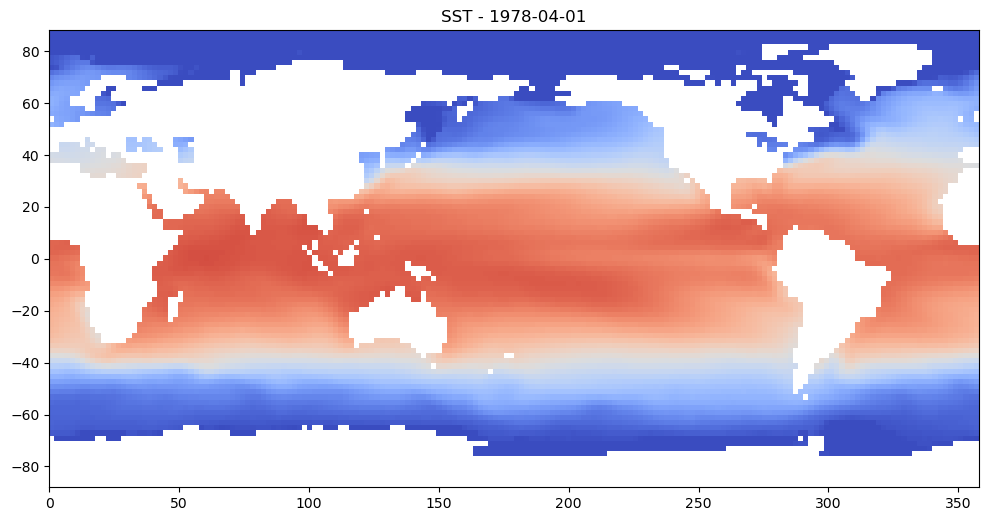

In [4]:
# Load the dataset
ds = xr.tutorial.open_dataset('ersstv5')

# Mask missing values
fill_value = ds['sst'].attrs.get('_FillValue', -999.9)
sst = ds['sst'].where(ds['sst'] != fill_value)
sst = sst[:100]

# Setup figure
fig, ax = plt.subplots(figsize=(12, 6))
cmap = 'coolwarm'
vmin = float(sst.min().values)
vmax = float(sst.max().values)

# Initial frame
# mesh = ax.pcolormesh(ds['lon'], ds['lat'], sst.isel(time=0), shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
img = ax.imshow(sst.isel(time=0), cmap=cmap, vmin=vmin, vmax=vmax, 
                 extent=[float(ds['lon'].min()), float(ds['lon'].max()),
                         float(ds['lat'].min()), float(ds['lat'].max())],
                 )

# create title once, grab the Text handle
title = ax.set_title(f'SST – {str(ds["time"].values[0])[:10]}')

# ── Animation callback ──────────────────────────────────────────────
def update(frame):
    img.set_data(sst.isel(time=frame))
    title.set_text(f'SST - {str(ds["time"].values[frame])[:10]}')
    return [img, title]                # include title for blitting

# def update(frame):
#     img.set_data(sst.isel(time=frame))
#     # img.set_title(f'AMOC at Time Step {frame}')
#     return [img]


# Create the animation
amoc_ani = FuncAnimation(fig, update, frames=len(sst['time']), interval=200, blit=True)

# Display the animation
HTML(amoc_ani.to_jshtml())


## Fourier Neural Operator

Now we can define the Fourier Neural Operator.

### 3D Fourier convolution neural network

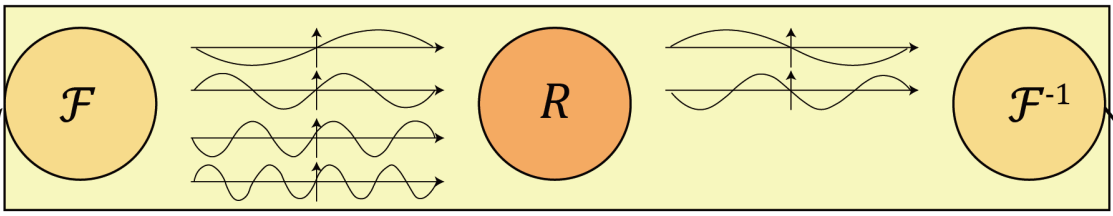

$$(R\cdot (\mathcal{F}v_t))_{k,l} = \sum_{j=i}^{d_v}R_{k,l,j}(\mathcal{F}v_t)_k,j$$

$$(\mathcal{K}(\phi)v_t)(x) = \mathcal{F}^{-1}\left((R\cdot (\mathcal{F}v_t\right)(x)$$

### Arguments:

`in_channels`: Number of input channels, the number of features going into this layer.

`out_channels`: Number of output channels, the feature dimension after this layer.

`modes`: Number of Fourier modes to keep per spatial dimension (low-frequency truncation).

### forward:
'x': 3d input, dimension is `x.shape == [batch_size, in_channels, depth, height, width]`


### 🎯 Why Do We Set a Mode Number in FNO?

1. Focus on Low-Frequency Content:

    Physical systems governed by PDEs (e.g., fluids, heat, waves) often have most of their important structure in low frequencies.

    By retaining only the first several Fourier modes, the model focuses on the global, smooth patterns, which are typically the most relevant.

2.  Implicit Regularization:

    Ignoring high-frequency modes acts like a low-pass filter, which helps:

    - Prevent overfitting

    - Improve generalization

    - Stabilize training


In [15]:
class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv3d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # 2 modes per dimension max, i.e. 6 modes
        self.modes = modes  
    
        # Scale used to initialize weights
        self.scale = (1 / (in_channels * out_channels))
        
        # Weights for different convolution operations in Fourier space
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes, modes,
                                                             modes, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes, modes,
                                                             modes, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes, modes,
                                                             modes, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes, modes,
                                                             modes, dtype=torch.cfloat))
        
    def complex_multi_3D(self, inputs, weights):
        # Complex multiplication between inputs and weights
        return torch.einsum("bixyz,ioxyz->boxyz", inputs, weights)
    
    def forward(self, x):
        
        batchsize = x.shape[0]
        
        # Calculating the Fourier coefficients, i.e. applying FFT to x and swapping the order of dimensions
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])
        
        # Initialize output tensor in Fourier space with the following dimension [batch, out, x[-3], x[-2], x[-1]/2]
        ## Prepares an empty complex tensor to hold the filtered Fourier modes.
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        

        # Multiply the relevant Fourier modes with the corresponding weights
        out_ft[:, :, :self.modes, :self.modes, :self.modes] = self.complex_multi_3D(x_ft[:, :, :self.modes, :self.modes, :self.modes], self.weights1)
        
        out_ft[:, :, -self.modes:, :self.modes, :self.modes] = self.complex_multi_3D(x_ft[:, :, -self.modes:, :self.modes, :self.modes], self.weights2)
        
        out_ft[:, :, :self.modes, -self.modes:, :self.modes] = self.complex_multi_3D(x_ft[:, :, :self.modes, -self.modes:, :self.modes], self.weights3)

        out_ft[:, :, -self.modes:, -self.modes:, :self.modes] = self.complex_multi_3D(x_ft[:, :, -self.modes:, -self.modes:, :self.modes], self.weights4)
        
        
        # Calculate the inverse Fourier transform to get the final output in real space
        result = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return result

### Fourier Block Neural Network
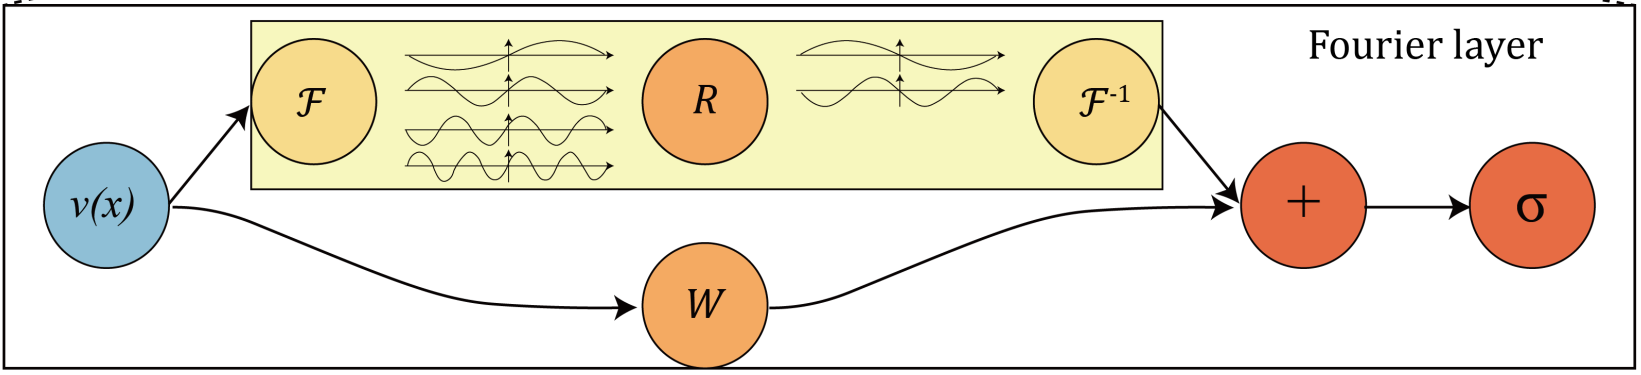
$$\sigma\left(Wv_t(x)+(\mathcal{K}(a,\phi)v_t)(x)\right)$$

where $W$ is a linear operator, $a$ is a vector of learnable parameters, $\phi$ is a vector of learnable parameters, and $\sigma$ is a non-linear activation function.


### 🔁 Step-by-Step Breakdown

1. **Input Field $v(x)$**: Intermediate inputs, may have multiple channels.

2. **Top Path — Fourier Transform Branch**:
    - $\mathcal{F}$: Applies the **Fast Fourier Transform (FFT)** to project the input into frequency space.
    - $R$: A **learned linear transformation** (complex-valued) is applied to selected low-frequency modes.
    - $\mathcal{F}^{-1}$: Applies the **Inverse FFT** to return the signal to the spatial domain.
    - This path captures **global patterns** efficiently by working in the frequency domain.

4. **Bottom Path — Local Feedforward Branch**:
    - $W$: A **pointwise** linear transformation across channels (1D convolution with kernel size 1) applied directly in the spatial domain, capturing local interactions.
    - 1D Convolution Makes the Layer Resolution-Agnostic

5. **Combination**:
   - The results from both branches are **added** together using a residual connection.
   - The **`+` operator** merges global (Fourier) and local (linear) information.

6. **Nonlinearity**:
   - $\sigma$: A **nonlinear activation function**.



---

### ✅ Why Use Both Paths?

- The **Fourier path** captures long-range dependencies using global information.
- The **linear path** complements it by retaining local flexibility.
- Their combination forms a powerful **operator-learning block**.

In [16]:
class FourierLayerBlock(nn.Module):
    """
    A single FNO block:
      • Spectral 3-D convolution  (x_sup)
      • Channel-wise 1-D conv     (x_inf)
      • ReLU on the sum
    """
    def __init__(self, modes: int, width: int):
        super().__init__()
        self.rama_sup = SpectralConv3d(width, width, modes)
        self.rama_inf = nn.Conv1d(width, width, kernel_size=1)

    def forward(self, x):
        """
        x: [B,  C=width, Sx, Sy, Sz]   (Sz == T_out)
        """
        B, C, Sx, Sy, Sz = x.shape

        # spectral branch
        x_sup = self.rama_sup(x)

        # 1-D point-wise branch
        x_inf = self.rama_inf(x.view(B, C, -1))          # [B, C, Sx*Sy*Sz]
        x_inf = x_inf.view(B, C, Sx, Sy, Sz)

        # non-linearity
        return F.relu(x_sup + x_inf)

### 3D Fourier Neural Operator

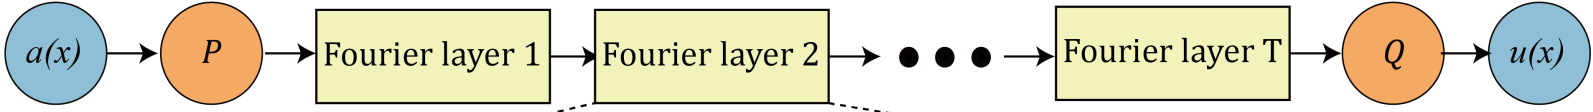

is the 3D Fourier Neural Operator. 3 dimensions are $x$, $y$, and $t$.

### Task: Spatiotemporal Forecasting with `FNO3D`

The `FNO3D` model is designed to perform **spatiotemporal forecasting** using a history of field values (e.g., temperature, velocity) across a 3D spatial grid.

---

### Input and Output Shapes

```
# Input:  [B, Sx, Sy, T_in]     (history cube)
# Output: [B, Sx, Sy, T_out]    (forecast cube)
```

### `_build_grid`: Constructing Spatiotemporal Coordinate Grids

This helper function creates **normalized coordinate grids** `xs, ys, ts` that will be concatenated with the model input to provide **positional encoding** in space and time.

Fourier Neural Operators are **resolution-agnostic**, but they require knowledge of the **relative position** of each point in the domain. This function builds:

- A **spatial grid** over dimensions `Sx` and `Sy` (e.g., x/y axes)
- A **temporal grid** over the forecast horizon `T_out`

These grids are used to **inject coordinate information** into the model, improving expressiveness and generalization.


In [5]:
# ───────────────────────────────────────────────────────────
# 3-D Fourier Neural Operator
# ───────────────────────────────────────────────────────────
class FNO3D(nn.Module):
    """
    • Input  : [B, Sx, Sy, T_in]                (history cube)
    • Output : [B, Sx, Sy, T_out]               (forecast cube)
    """
    def __init__(self,
                 modes:  int,
                 width:  int,
                 T_in:   int,
                 T_out:  int,
                 layers: int = 4):
        super().__init__()

        self.modes   = modes
        self.width   = width
        self.layers  = layers
        self.T_in    = T_in
        self.T_out   = T_out

        # Linear projection: 3 coords  +  T_in history  →  width
        self.fc0 = nn.Linear(T_in + 3, width)

        # Fourier blocks
        self.fblocks = nn.ModuleList(
            [FourierLayerBlock(modes, width) for _ in range(layers)]
        )

        # Final point-wise MLP
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, 1)

        # coordinate buffers (lazy)
        self.gridx = self.gridy = self.gridt = None
        self.Sx = self.Sy = self.Sz = 0       # cache grid sizes

    # ───────────────────────────────────────────────
    # forward
    # ───────────────────────────────────────────────
    def forward(self, x):
        """
        x : [B, Sx, Sy, T_in]
        """
        B, Sx, Sy, T_in = x.shape
        assert T_in == self.T_in, "Input tensor’s T dimension ≠ T_in"

        # (re-)build coordinate grids if shape changed
        if (Sx, Sy, self.T_out) != (self.Sx, self.Sy, self.Sz) or self.gridx is None:
            self._build_grid(Sx, Sy, x.device)

        # ----- create feature tensor --------------------------------------
        # history → feature axis,  then replicate along forecast time Sz
        #   x_feat : [B, Sx, Sy, Sz, T_in]
        x_feat = x.unsqueeze(3).repeat(1, 1, 1, self.Sz, 1)

        # concat coords (each  [1,Sx,Sy,Sz,1]  → broadcast to batch)
        gx = self.gridx.expand(B, -1, -1, -1, -1)
        gy = self.gridy.expand(B, -1, -1, -1, -1)
        gt = self.gridt.expand(B, -1, -1, -1, -1)

        # [B, Sx, Sy, Sz, T_in + 3]
        x_cat = torch.cat([gx, gy, gt, x_feat], dim=-1)
        
        # ----- point-wise projection  -------------------------------------
        # result : [B, Sx, Sy, Sz, width]
        x = self.fc0(x_cat)

        # transpose for Fourier blocks: [B, width, Sx, Sy, Sz]
        x = x.permute(0, 4, 1, 2, 3)

        # ----- spectral stack  -------------------------------------------
        for blk in self.fblocks:
            x = blk(x)

        # back to  [..., width] last
        x = x.permute(0, 2, 3, 4, 1)          # [B, Sx, Sy, Sz, width]

        # ----- point-wise head  ------------------------------------------
        x = F.relu(self.fc1(x))
        x = self.fc2(x).squeeze(-1)           # [B, Sx, Sy, Sz]

        return x                              # == forecast [T_out] cube

    # ───────────────────────────────────────────────
    # helper: build coord grids
    # ───────────────────────────────────────────────
    def _build_grid(self, Sx, Sy, device):
        self.Sx, self.Sy, self.Sz = Sx, Sy, self.T_out

        xs = torch.linspace(0, 1, Sx, device=device)
        ys = torch.linspace(0, 1, Sy, device=device)
        ts = torch.linspace(0, 1, self.T_out, device=device)

        # → shape  [1, Sx, Sy, Sz, 1]
        self.gridx = xs.view(1, Sx, 1, 1, 1).repeat(1, 1, Sy, self.T_out, 1)
        self.gridy = ys.view(1, 1, Sy, 1, 1).repeat(1, Sx, 1, self.T_out, 1)
        self.gridt = ts.view(1, 1, 1, self.T_out, 1).repeat(1, Sx, Sy, 1, 1)



## Loss Function

In [6]:
# Loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        # Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        # Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

## Training

### Data preparation

We'll train the model with pre-generated data. 

In [8]:
dummy_value = 0.0

# 1. Load the SST dataset
ds = xr.tutorial.open_dataset('ersstv5')
sst = ds['sst']

sst = sst.fillna(dummy_value)  
# shape = (T, H, W)
data = sst.values.astype('float32')
T, H, W = data.shape

# 2. Define sliding‐window parameters
T_in   = 10                     # number of input time steps
T_pred = 12              # number of steps to predict
step   = 1                       # sliding window stride
# total number of (input, target) pairs
n_samples = (T - (T_in + T_pred)) // step + 1

# 3. Build arrays of shape (n_samples, H, W, T_in) and (n_samples, H, W, T_pred)
X = np.zeros((n_samples, T_in, H, W),  dtype='float32')
Y = np.zeros((n_samples, T_pred, H, W), dtype='float32')

for i in range(n_samples):
    start = i * step
    X[i] = data[start : start + T_in]
    Y[i] = data[start + T_in : start + T_in + T_pred]

# 4. Move time‐axis to last dim for FNO convention (batch, H, W, T)
X = np.transpose(X, (0, 2, 3, 1))
Y = np.transpose(Y, (0, 2, 3, 1))

# 5. Split into train / eval / test
ntrain = int(0.8 * n_samples)
neval  = int(0.2 * ntrain)
ntest  = n_samples - ntrain

# train
train_X = torch.from_numpy(X[:ntrain])
train_Y = torch.from_numpy(Y[:ntrain])
# eval (from end of train split)
eval_X = torch.from_numpy(X[ntrain : ntrain+neval])
eval_Y = torch.from_numpy(Y[ntrain : ntrain+neval])
# test (the remainder)
test_X = torch.from_numpy(X[ntrain+neval :])
test_Y = torch.from_numpy(Y[ntrain+neval :])

# 6. Create DataLoaders
batch_size = 10

train_loader = DataLoader(TensorDataset(train_X, train_Y),
                          batch_size=batch_size, shuffle=True)
eval_loader  = DataLoader(TensorDataset(eval_X,  eval_Y),
                          batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(test_X,  test_Y),
                          batch_size=batch_size, shuffle=False)

# confirm shapes
print(f"Train: {train_X.shape} → {train_Y.shape}")
print(f"Eval:  {eval_X.shape} → {eval_Y.shape}")
print(f"Test:  {test_X.shape} → {test_Y.shape}")


Train: torch.Size([482, 89, 180, 10]) → torch.Size([482, 89, 180, 12])
Eval:  torch.Size([96, 89, 180, 10]) → torch.Size([96, 89, 180, 12])
Test:  torch.Size([25, 89, 180, 10]) → torch.Size([25, 89, 180, 12])


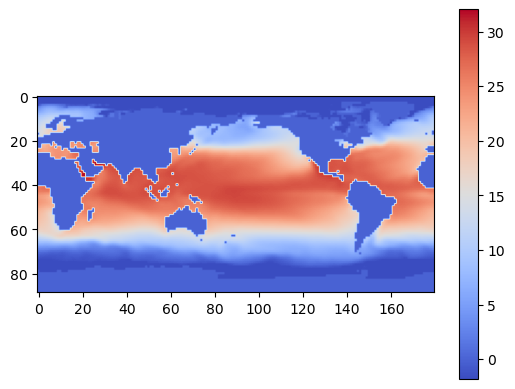

In [9]:
plt.imshow(sst.isel(time=30), cmap='coolwarm')
plt.colorbar()

### Functions for training

#### Function to train an epoch

In [10]:
sst = ds['sst']
mask = torch.tensor(~np.isnan(sst.values)[0], device=device).unsqueeze(-1)

def train_epoch(dataloader, model, optimizer, scheduler, loss_function):
    model.train()
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        y = y * mask
        B, sx, sy, _ = x.shape
        out = (model(x) * mask).view(B, sx, sy, T_pred)
        loss = loss_function(out.view(B, -1), y.view(B, -1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    model.eval()


#### Function to evaluate an epoch

In [11]:
def eval_epoch(dataloader, model, loss_function, num_batches=None):
    # Freeze model parameters
    with torch.no_grad():
        # Historiales
        losses, mses = [], []
        
        # Evaluates this epoch with num_batches
        test_l2 = 0
        for a, u_true in take(dataloader, num_batches):
            B, sx, sy, _ = a.shape
            a = a.to(device)
            u_true = u_true.to(device)
            u_true = u_true * mask
            
            out = model(a*mask).view(B, sx, sy, T_pred)
            
            # Evaluamos con las funciones de perdida
            test_l2 = loss_function(out.view(1, -1), u_true.view(1, -1)).item()
            test_mse = F.mse_loss(out.view(1, -1), u_true.view(1, -1), reduction='mean')
            losses.append(test_l2)
            mses.append(test_mse.cpu())
            
        # Get mean loss and mean mse
        loss = np.mean(losses)
        mse = np.mean(mses)
        
        return loss, mse

#### Function to train the model

In [12]:
def train_model(model, train_dataloader, test_dataloader, lr=1e-3, epochs=20, scheduler_step=100, scheduler_gamma=0.05, train_batches=None, test_batches=None):
    # Función de pérdida
    loss_function = LpLoss(size_average=False)
    # loss_function = torch.nn.L1Loss()
    
    # Usamos al optimizador Adam
    # opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    # opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Usamos el scheduler StepLR para reducir de manera constante el learning rate después de ciertos pasos
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=scheduler_step, gamma=scheduler_gamma)
    
    # Inicializamos los historiales
    loss_hist, mse_hist = [], []
    
    # Entrenamos
    for epoch in trange(epochs):
        
        # Entrenamos la época
        train_epoch(train_dataloader, model, opt, scheduler, loss_function)

        # Evaluamos la época en entrenamiento
        trn_loss, trn_mse = eval_epoch(train_dataloader, model, loss_function, train_batches)
        
        # Evaluamos la época en prueba
        tst_loss, tst_mse = eval_epoch(test_dataloader, model, loss_function, test_batches)

        # Guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        mse_hist.append([trn_mse, tst_mse])
        
    return loss_hist, mse_hist

### Training the model

In [17]:
# Create model
model = FNO3D(modes=6, width=20, T_in=T_in, T_out=T_pred).to(device)

In [ ]:
# Train model
loss_hist, mse_hist = train_model(model, train_loader, eval_loader, lr=1e-3, epochs=100)

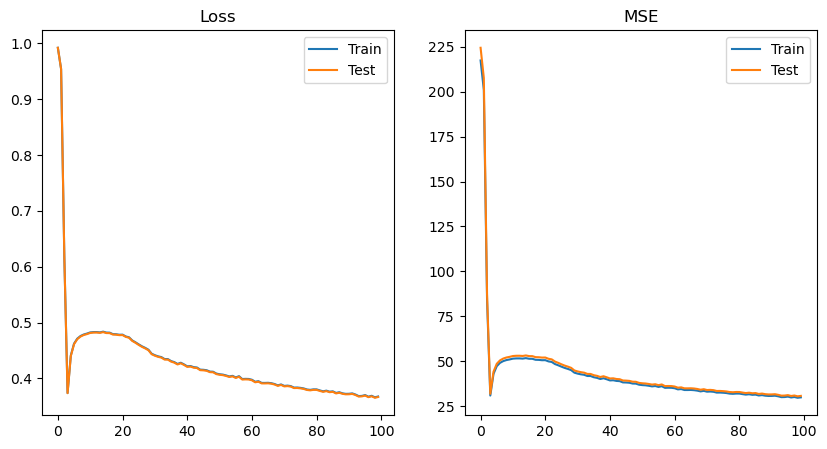

In [15]:
# Separate train and test loss as well as train and test mse
train_loss_hist = [loss[0] for loss in loss_hist]
test_loss_hist = [loss[1] for loss in loss_hist]
train_mse_hist = [mse[0] for mse in mse_hist]
test_mse_hist = [mse[1] for mse in mse_hist]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_loss_hist, label='Train')
ax[0].plot(test_loss_hist, label='Test')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(train_mse_hist, label='Train')
ax[1].plot(test_mse_hist, label='Test')
ax[1].set_title('MSE')
ax[1].legend()
plt.show()

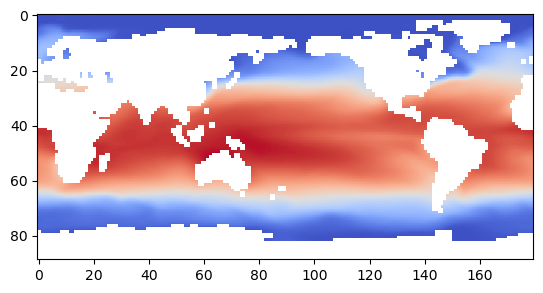

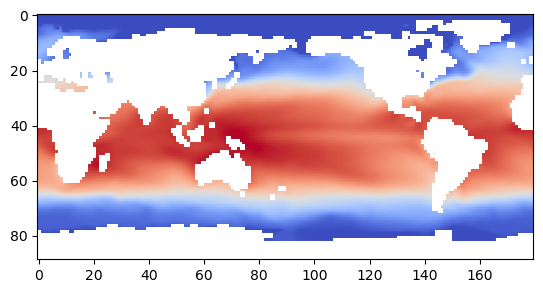

In [25]:
x, y = next(iter(eval_loader))
x = x.to(device)
y = y.to(device)
predict = model(x)*mask
predict[~mask.expand(10, 89, 180, 12)] = np.nan
y[~mask.expand(10, 89, 180, 12)] = np.nan
plt.imshow(predict[0,..., 0].cpu().detach().numpy(), cmap='coolwarm')
plt.figure()
plt.imshow(y[0,..., 0].cpu().detach().numpy(), cmap='coolwarm')